In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

#Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Measures
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

#Plots
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)

# Measures

In [2]:
#-------Group Fairness--------
def group_fairness(df, sensible_attribute, privileged_value, outcome):
    return df[df[sensible_attribute] != privileged_value][outcome].mean() / df[df[sensible_attribute] == privileged_value][outcome].mean()

In [3]:
def edit_group_fairness(df, sensible_attribute, privileged_value, outcome, balance):
    dataset = df.drop( df[ (df[sensible_attribute] == privileged_value) & (df[outcome] == 1 ) ].sample(frac=balance).index)
    return dataset


In [4]:
n_steps = 5
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}
classifier_names = list(classifiers.keys())

metrics = {
    'Accuracy': np.zeros((len(classifiers), n_steps)),
    'Precision': np.zeros((len(classifiers), n_steps)),
    'Recall': np.zeros((len(classifiers), n_steps)),
    'F1 Score': np.zeros((len(classifiers), n_steps))
}

# Dataset

In [5]:
compas = pd.read_csv('dataset/compas/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv')
compas['Two_yr_Recidivism'] = 1 - compas['Two_yr_Recidivism']
compas.rename(columns={'Two_yr_Recidivism':'No_Two_yr_Recidivism'},inplace=True)
y_class = 'No_Two_yr_Recidivism'
compas['Black_Male'] = np.where( (compas['African_American'] == 1) & (compas['Female'] == 0), 1, 0)
sensible_attribute='African_American'
privileged_value=0
#sensible_attribute='Black_Male'
#privileged_value=0
data=compas
dataset_name='compas'
measures_steps = {
    'Group Fairness': [0,0.3,0.4,0.5,0.6]
}

In [8]:
nlsb = pd.read_csv('dataset/nlsy.csv')

nlsb['grade90'].replace({
    '3RD GRADE': 0,
    '4TH GRADE': 1,
    '5TH GRADE': 2,
    '6TH GRADE': 3,
    '7TH GRADE': 4,
    '8TH GRADE': 5,
    '9TH GRADE': 6,
    '10TH GRADE': 7,
    '11TH GRADE': 8,
    '12TH GRADE': 9,
    '1ST YR COL': 10,
    '2ND YR COL': 11,
    '3RD YR COL': 12,
    '4TH YR COL': 13,
    '5TH YR COL': 14,
    '6TH YR COL': 15,
    '7TH YR COL': 16,
    '8TH YR COL OR MORE': 17
}, inplace=True)

nlsb['gender'].replace({'Female':0, 'Male':1},inplace=True)
nlsb['race'].replace(dict.fromkeys(['AMERICAN','FRENCH','GERMAN','GREEK','ENGLISH','IRISH','ITALIAN','POLISH','PORTUGUESE','RUSSIAN','SCOTTISH','WELSH'],'WHITE'),inplace=True)
nlsb['race'].replace(dict.fromkeys(['HAWAIIAN', 'INDIAN', 'FILIPINO', 'KOREAN', 'CHINESE','JAPANESE'],'ASIAN-PAC-ISLANDER'),inplace=True)
nlsb['race'].replace(dict.fromkeys(['NATIVE-AMERICAN'],'AMERICAN-INDIAN-ESKIMO'),inplace=True)
nlsb['race'].replace(dict.fromkeys(['CUBAN','CHICANO','MEXICAN','MEXICAN-AMERICAN','OTHER-HISPANIC','OTHER-SPANISH','PUERTORICAN'],'HISPANIC'),inplace=True)
nlsb['race'].replace({'NONE':'OTHER'},inplace=True)

nlsb['genhealth'].replace({'Poor': 0,
                           'Fair': 1,
                           'Good': 2,
                           'Very Good': 3,
                           'Excellent': 4},inplace=True)

nlsb['height'] = round(nlsb['height']*0.30)
nlsb['weight'] = round(nlsb['weight']*0.45)
nlsb['jobtrain90'].replace({'No':0,
                            'Yes':1},inplace=True)

enc = LabelEncoder()
for i in nlsb.columns:
    if nlsb[i].dtype == "object":
        nlsb[i]=enc.fit_transform(nlsb[i])
#nlsb['age'] = pd.cut(nlsb['age'],4, labels=[0,1,2,3])
y_class = 'income96gt17'
sensible_attribute='gender'
privileged_value=1
data = nlsb.drop(['id','income96'],axis=1)
dataset_name = 'nlsy'

measures_steps = {
    'Group Fairness': [0, 0.45, 0.7, 0.75, 0.8]
}

In [11]:
law_school = pd.read_csv('dataset/law_school.csv')

law_school['gender'].replace({'female':0, 'male':1},inplace=True)
law_school['race1'].replace({'non-white':0, 'white':1},inplace=True)
law_school['bar'].replace({False:0,True:1},inplace=True)
law_school['ugpagt3'].replace({False:0,True:1},inplace=True)

y_class = 'ugpagt3'
sensible_attribute='gender'#'race1'
privileged_value=0
data = law_school.drop(['ugpa'],axis=1)
dataset_name = 'law_school'
measures_steps = {
    'Group Fairness': [0,0.3,0.4,0.5,0.6]
}

In [15]:
bank = pd.read_csv('dataset/bank.csv')
bank.replace({'no':0, 'yes':1},inplace=True)
bank['y'].replace({2:0},inplace=True)
bank['month'].replace({'jan':1, 'feb':2,'mar':3, 'apr':4,'may':5, 'jun':6, 'jul':7, 'aug':8,'sep':9,'oct':10, 'nov':11, 'dec':12}, inplace=True)

enc = LabelEncoder()
for i in bank.columns:
    if bank[i].dtype == "object":
        bank[i]=enc.fit_transform(bank[i])

y_class = 'y'
#sensible_attribute='age'
sensible_attribute='marital'
privileged_value=1
bank['age'] = pd.cut(bank['age'], bins=[0,25,60,100],labels=[0,1,2])
data=bank.drop(['id','contact','day_of_week','month'],axis=1)

dataset_name = 'bank'
measures_steps = {
    'Group Fairness': [0,0.2,0.3,0.4,0.5]
}

In [18]:
adult = pd.read_csv('dataset/adult.csv')
adult['income'] = adult['income'].replace('<=50K',0).replace('>50K',1)
adult['sex'].replace({'Female':0, 'Male':1})
data = adult.drop(['education', 'fnlwgt'], axis=1)
data.replace('?',np.NaN,inplace=True)
data.fillna(method='ffill',inplace=True)


enc = LabelEncoder()
for i in data.columns:
    if data[i].dtype == 'object':
        data[i]=enc.fit_transform(data[i])

y_class='income'

sensible_attribute = 'sex'
privileged_value=1
dataset_name='adult'
measures_steps = {
    'Group Fairness': [0, 0.5, 0.72, 0.8,0.82]
}

In [21]:
german = pd.read_csv('dataset/german_credit_data.csv')
german['Risk'].replace({'bad':0, 'good':1}, inplace=True)
german['Age'] = pd.cut(german['Age'], bins=[0,25,100],labels=[0,1])
data = german.drop(['id'], axis=1)


enc = LabelEncoder()
for i in data.columns:
    if data[i].dtype == 'object':
        data[i]=enc.fit_transform(data[i])

y_class='Risk'

sensible_attribute = 'Sex'
privileged_value=1
dataset_name='german'
measures_steps = {
    'Group Fairness': [0,0.2,0.3,0.4,0.5]
}

In [24]:
credit = pd.read_csv('dataset/UCI_Credit_Card.csv')
credit['SEX'].replace({2:0},inplace=True)
credit['default.payment.next.month'] = 1-credit['default.payment.next.month']
data = credit.drop(['ID'],axis=1)
y_class='default.payment.next.month'
sensible_attribute = 'SEX'
privileged_value=0
dataset_name='credit'
measures_steps = {
    'Group Fairness': [0,0.1,0.2,0.3,0.4]
}

# Train

In [25]:
measure_value = []
for ii, measure_steps in enumerate(measures_steps):

    for i, step in enumerate(measures_steps.get(measure_steps)):

        dataset = edit_group_fairness(data, sensible_attribute, privileged_value, y_class, step)
        measure_value.append(group_fairness(dataset, sensible_attribute, privileged_value, y_class))

        X = dataset.drop(y_class, axis=1)
        y = dataset[y_class]

        for j, (classifier_name, classifier) in enumerate(classifiers.items()):
            num_folds = 5
            kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            predictions = cross_val_predict(classifier, X_scaled, y, cv=kf)

            # Calculate metrics and store in the metrics dictionary
            metrics['Accuracy'][j, i] = accuracy_score(y, predictions)
            metrics['Precision'][j, i] = precision_score(y, predictions, average='weighted')
            metrics['Recall'][j, i] = recall_score(y, predictions, average='weighted')
            metrics['F1 Score'][j, i] = f1_score(y, predictions, average='weighted')

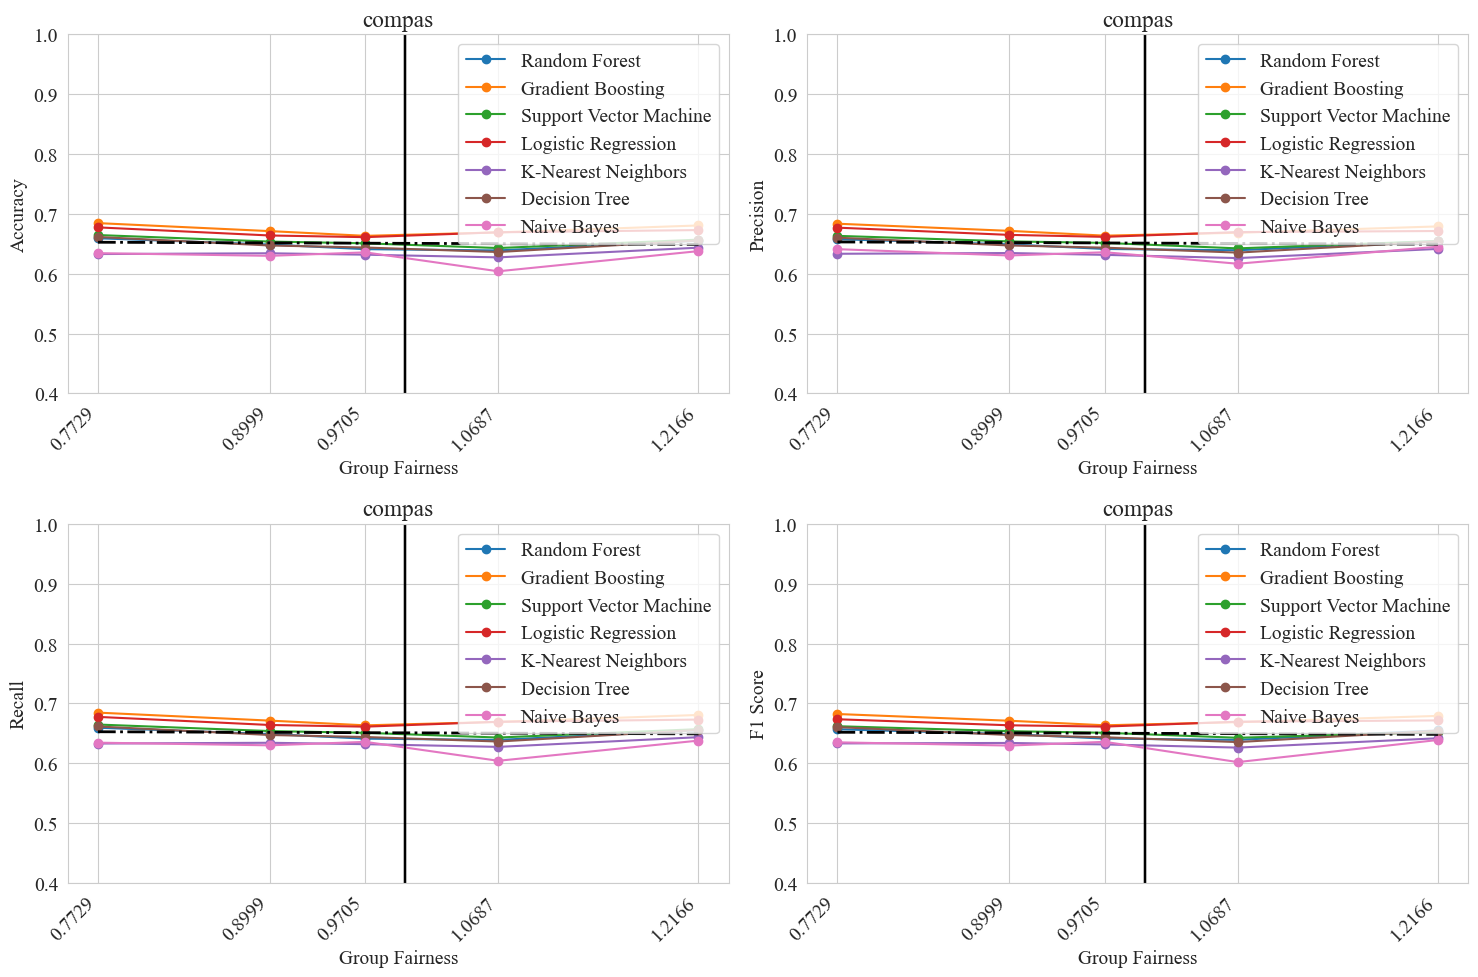

In [7]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/fairness_vs_perf_{dataset_name}.svg', format='svg')
plt.show()

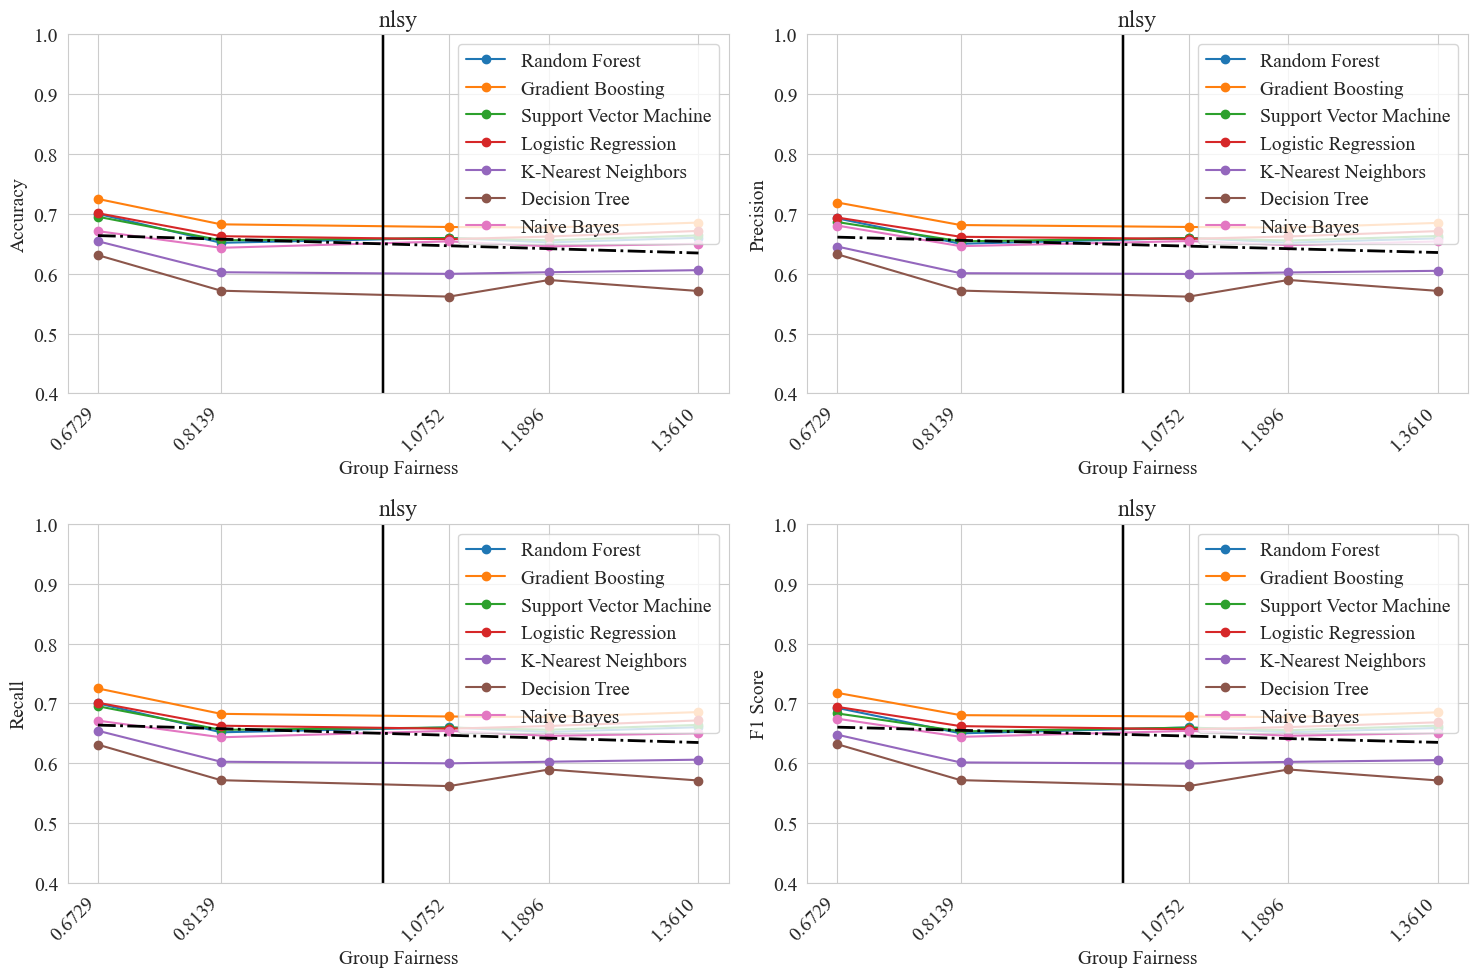

In [10]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/fairness_vs_perf_{dataset_name}.svg', format='svg')
plt.show()

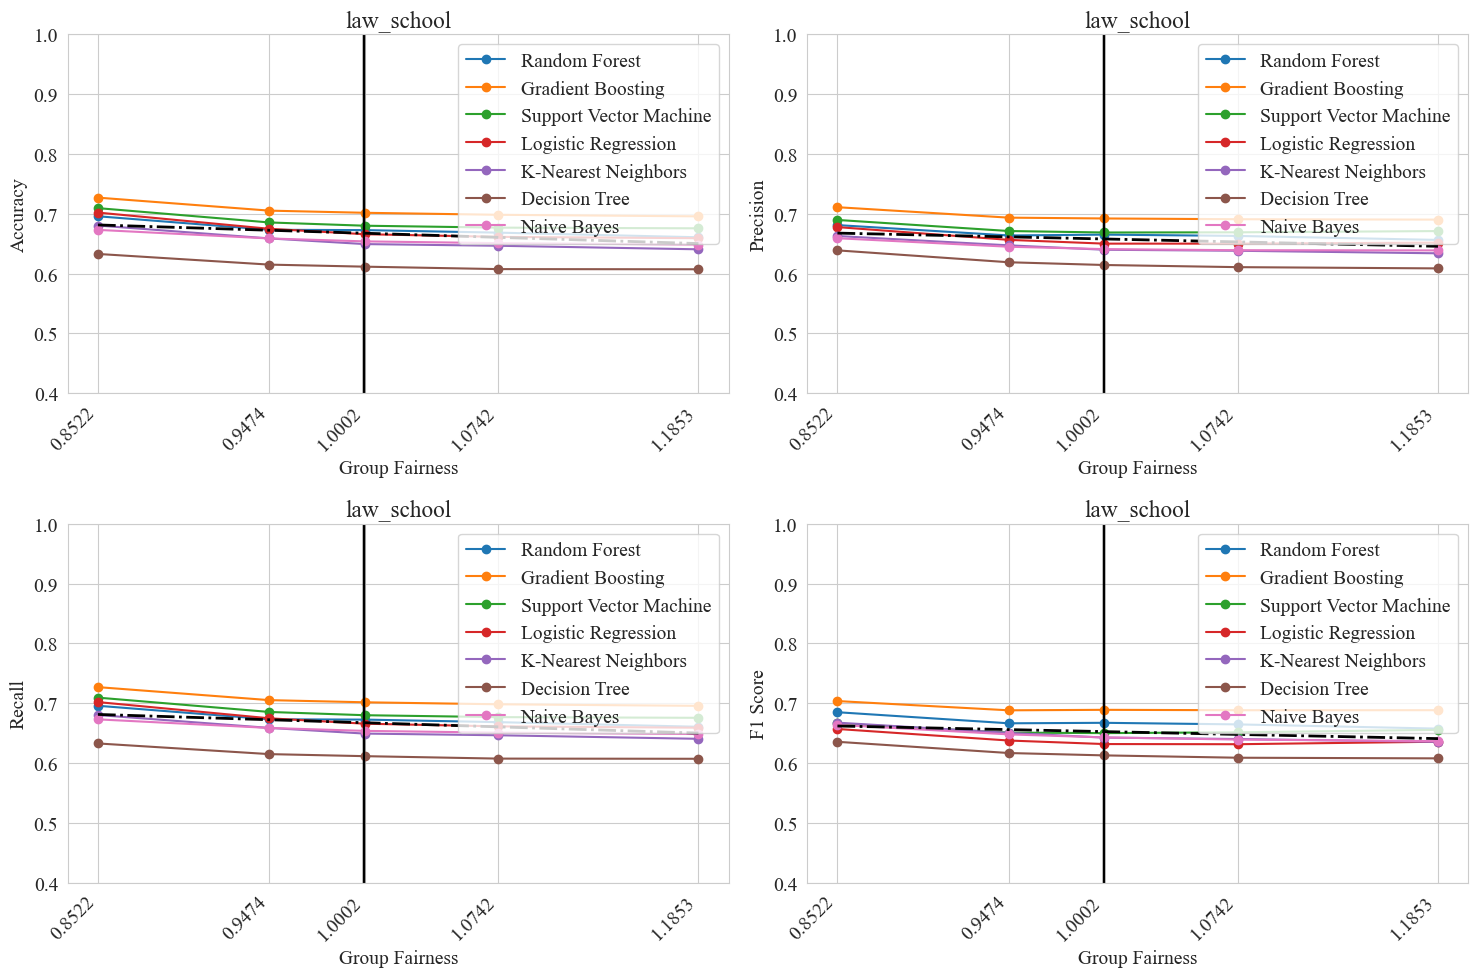

In [13]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/fairness_vs_perf_{dataset_name}.svg', format='svg')
plt.show()


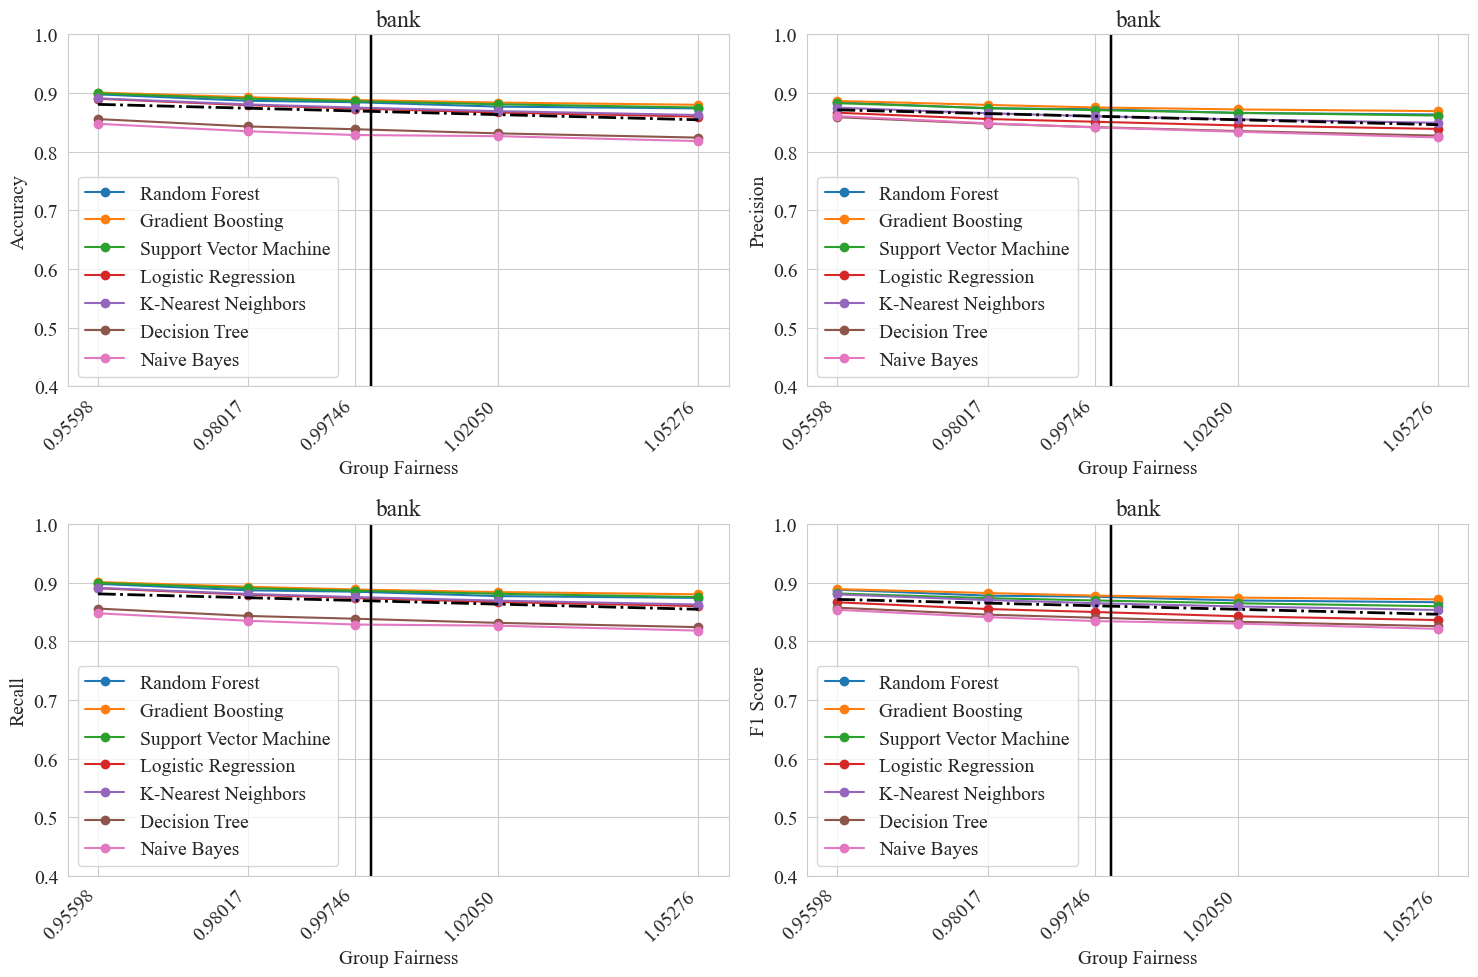

In [17]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/fairness_vs_perf_{dataset_name}.svg', format='svg')
plt.show()


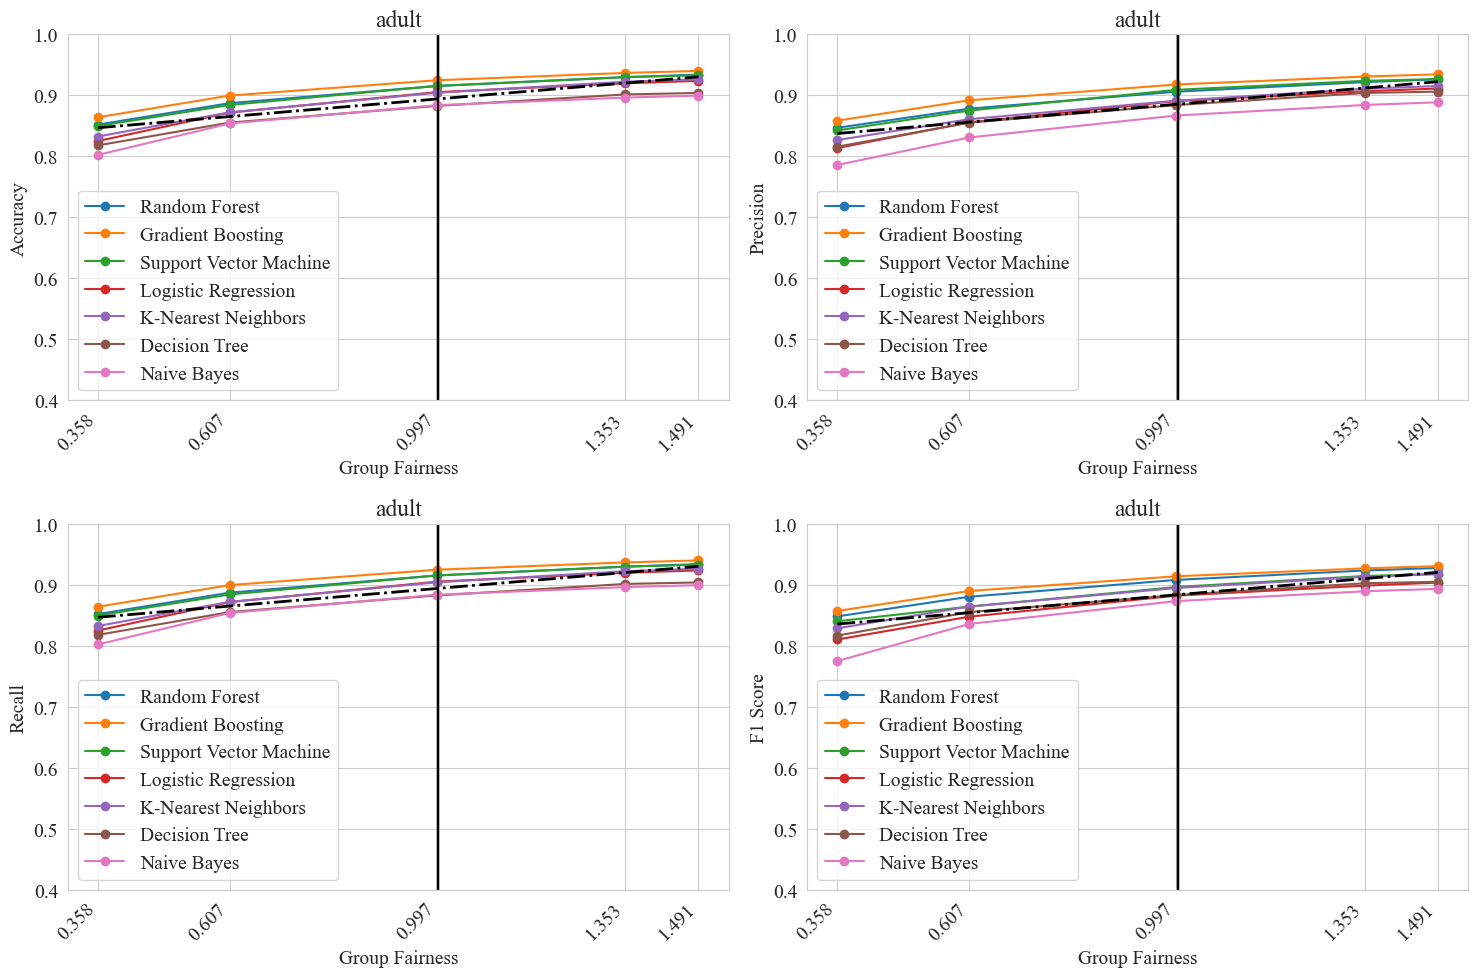

In [20]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/fairness_vs_perf_{dataset_name}.svg', format='svg')
plt.show()


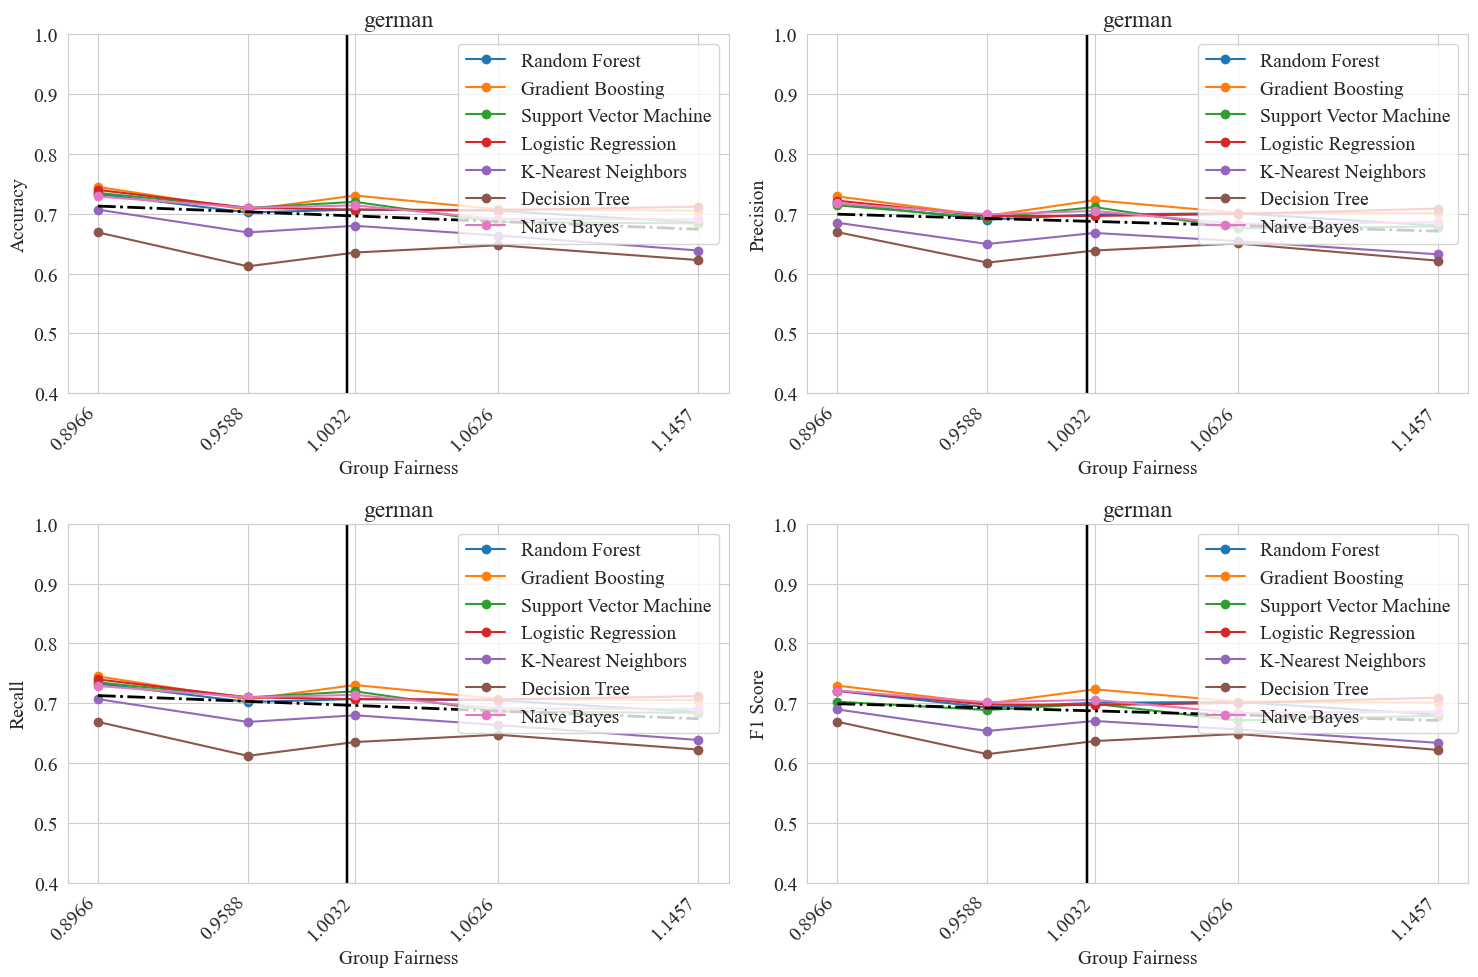

In [23]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/fairness_vs_perf_{dataset_name}.svg', format='svg')
plt.show()


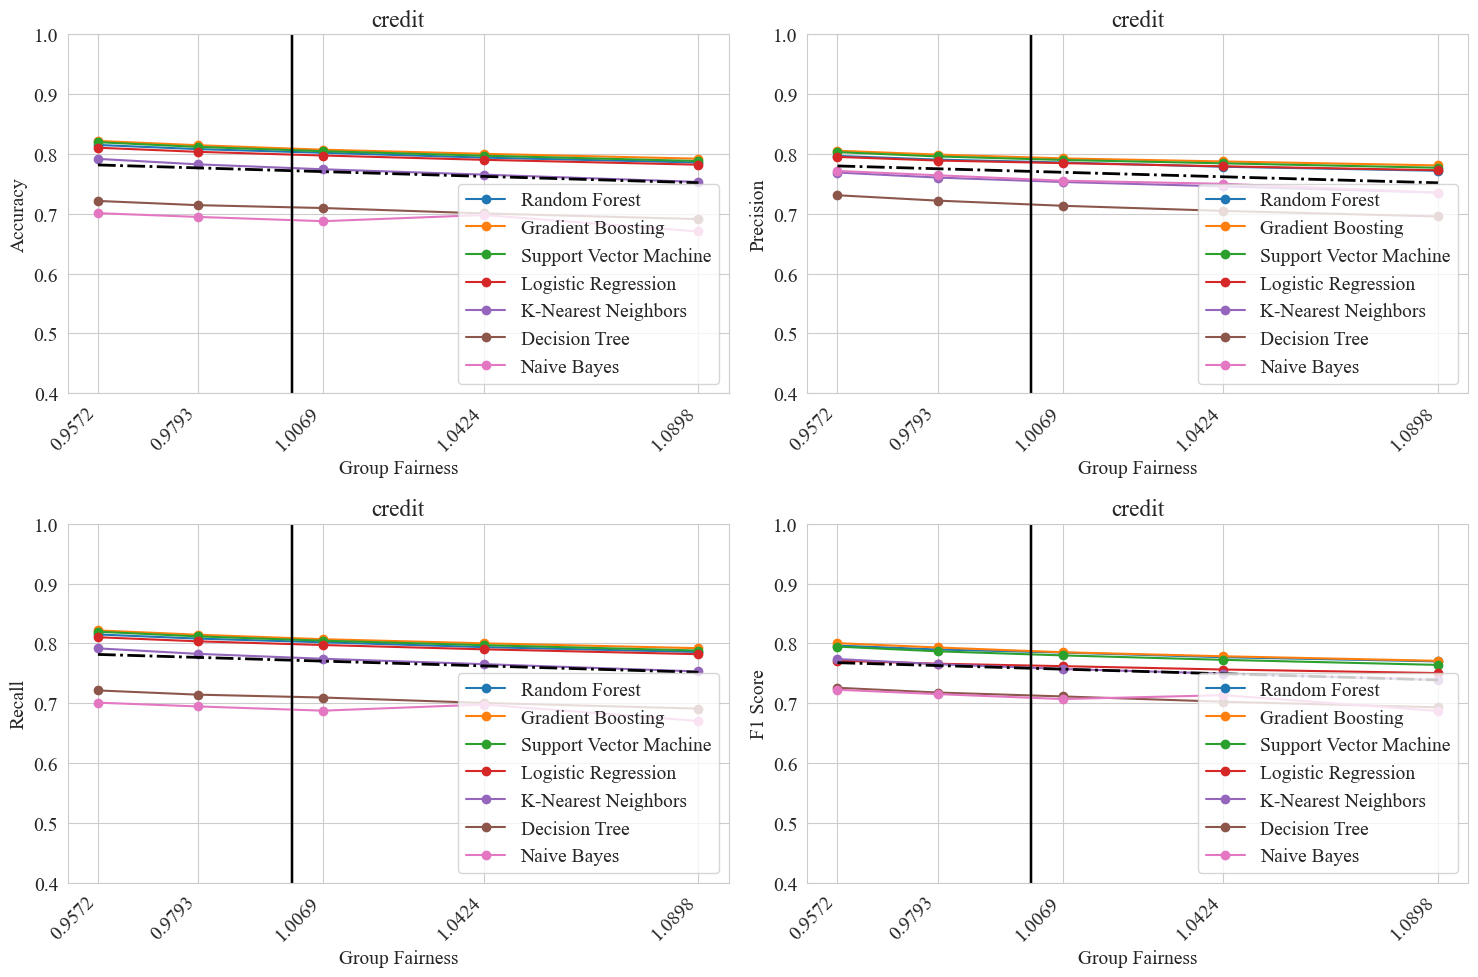

In [26]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.axvline(x = 1, color = 'black',)
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/fairness_vs_perf_{dataset_name}.svg', format='svg')
plt.show()
